<a href="https://www.kaggle.com/code/jhtkoo0426/london-quality-of-life-analysis?scriptVersionId=149083002" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Introduction
This notebook aims to uncover and analysis trends in housing prices, job salaries and "happiness" scores for all London boroughs.

We will be using the following datasets:
1. [Housing in London](https://www.kaggle.com/datasets/justinas/housing-in-london), with data from 1975-2020

# Loading packages

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import jedi

# Supressing Panda's scientific notation
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Pre-processing the Housing in London dataset
The Housing in London dataset provides us with **two** important features for our analysis:
1. Monthly/yearly average **housing prices**
2. Yearly median & mean **salary of residents** in the area

In [2]:
# Load the Housing in London dataset (monthly)
housing_data = pd.read_csv("/kaggle/input/housing-in-london/housing_in_london_monthly_variables.csv")
housing_data.head()

,date,area,average_price,code,houses_sold,no_of_crimes,borough_flag
0,1995-01-01,city of london,91449,E09000001,17.00,NaN,1
1,1995-02-01,city of london,82203,E09000001,7.00,NaN,1
2,1995-03-01,city of london,79121,E09000001,14.00,NaN,1
3,1995-04-01,city of london,77101,E09000001,7.00,NaN,1
4,1995-05-01,city of london,84409,E09000001,10.00,NaN,1


In [3]:
print(f"Number of rows in Housing in London dataset: {len(housing_data)}")

Number of rows in Housing in London dataset: 13549


## Remove unnecessary features

In [4]:
unnecessary_columns = columns=['no_of_crimes', 'code', 'borough_flag']

In [5]:
housing_data = housing_data.drop(columns=unnecessary_columns, axis=1, errors='ignore')
housing_data.head()

,date,area,average_price,houses_sold
0,1995-01-01,city of london,91449,17.00
1,1995-02-01,city of london,82203,7.00
2,1995-03-01,city of london,79121,14.00
3,1995-04-01,city of london,77101,7.00
4,1995-05-01,city of london,84409,10.00


## Processing null values

Identity which columns contain null values:

In [6]:
housing_null = housing_data.isna().mean()
housing_null = housing_null[housing_null > 0].sort_values(ascending=False)
housing_null

houses_sold   0.01
dtype: float64

In [7]:
housing_data = housing_data.fillna(0)
housing_data.head()

,date,area,average_price,houses_sold
0,1995-01-01,city of london,91449,17.00
1,1995-02-01,city of london,82203,7.00
2,1995-03-01,city of london,79121,14.00
3,1995-04-01,city of london,77101,7.00
4,1995-05-01,city of london,84409,10.00


## Convert `date` column into `datetime` data type

In [8]:
housing_data['date'] = pd.to_datetime(housing_data['date'])

## Separating the dataset with London boroughs entries and non-London boroughs entries
We will filter out all values in the `area` column that are not London boroughs.
> The London boroughs are the 32 local authority districts that together with the City of London make up the administrative area of Greater London, England; each is governed by a London borough council. (Source: https://en.wikipedia.org/wiki/London_boroughs)

In [9]:
areas = housing_data["area"]
f"Number of unique areas: {len(set(areas))}"

'Number of unique areas: 45'

From the above, there are 12 non-London borough areas. For now, we split the dataset into 2: London boroughs and areas that are not London boroughs.

In [10]:
boroughs = {'barking and dagenham', 'barnet', 'bexley', 'brent', 'bromley', 'camden', 'city of london', 'croydon', 'ealing', 'enfield',
            'greenwich', 'hackney', 'hammersmith and fulham', 'haringey', 'harrow', 'havering', 'hillingdon', 'hounslow', 'islington', 
            'kensington and chelsea', 'kingston upon thames', 'lambeth', 'lewisham', 'merton', 'newham', 'redbridge', 'richmond upon thames', 
            'southwark', 'sutton', 'tower hamlets', 'waltham forest', 'wandsworth', 'westminster'}

In [11]:
other_areas = set(areas) - boroughs
other_areas

{'east midlands',
 'east of england',
 'england',
 'inner london',
 'london',
 'north east',
 'north west',
 'outer london',
 'south east',
 'south west',
 'west midlands',
 'yorks and the humber'}

In [12]:
print(f"Number of boroughs: {len(boroughs)}")
print(f"Number of other areas: {len(other_areas)}")

Number of boroughs: 33
Number of other areas: 12


In [13]:
# Remove all non-borough rows
housing_data = housing_data[housing_data['area'].isin(boroughs)]
print(f"Number of rows in Housing in London dataset after preprocessing: {len(housing_data)}")

Number of rows in Housing in London dataset after preprocessing: 9936


## Aggregating housing prices by year
Since the dataset lists average housing prices and the number of houses sold per month, we aggregate the total amounts spent on house transactions for each borough per year.

In [14]:
housing_data['total_price'] = housing_data['average_price'] * housing_data['houses_sold']

In [15]:
housing_data = housing_data.groupby([housing_data['date'].dt.year, housing_data['area']])
housing_data = housing_data.agg({'average_price': 'mean', 'houses_sold': 'sum'})

In [16]:
housing_data = housing_data.reset_index()
housing_data = housing_data.rename(columns={'date': 'year'})
housing_data.head(10)

,year,area,average_price,houses_sold
0,1995,barking and dagenham,51818.00,1476.00
1,1995,barnet,91792.50,4689.00
2,1995,bexley,64291.58,3412.00
3,1995,brent,73029.92,3412.00
4,1995,bromley,81967.25,4742.00
5,1995,camden,120367.42,2688.00
6,1995,city of london,99085.00,159.00
7,1995,croydon,68923.33,5172.00
8,1995,ealing,81218.75,3997.00
9,1995,enfield,71984.25,4701.00


In [17]:
def plotHousingPriceTrend(housing_data):
    # Plot housing price trends from 1975 to 2021
    fig, ax = plt.subplots(figsize=(12, 8))

    colormap = plt.cm.gist_ncar
    ax.ticklabel_format(style='plain')
    sns.lineplot(data=housing_data, x='year', y='average_price', hue='area')

    plt.title('Average Price by Area Over Time')
    plt.xlabel('Year')
    plt.ylabel('Average Price')
    plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0, 1, len(boroughs)))))
    plt.legend(title='Area', title_fontsize='15', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

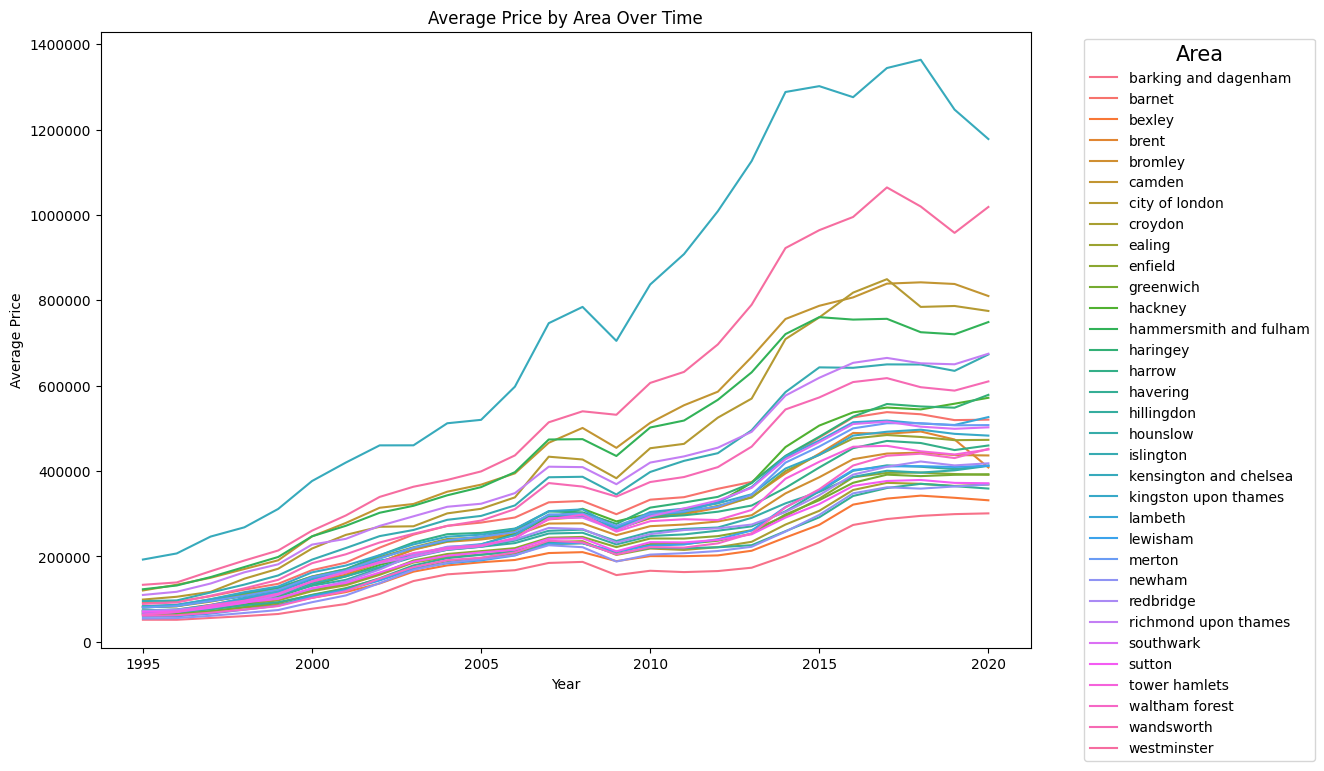

In [18]:
plotHousingPriceTrend(housing_data)